In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
comps = pd.read_csv("data/all_comps.csv")
names = pd.read_csv("data/all_names.csv")
ratings = pd.read_csv("data/all_ratings.csv")
results = pd.read_csv("data/all_results.csv")
stats = pd.read_csv("data/all_stats.csv")

In [29]:
comps

,season,codex,hill_size_x,k-point,meter value,gate factor,wind factor,id,training,place,gender,hill_size_y,team,type,date
0,2009,3245,134.0,120.0,1.8,NaN,NaN,2009JP3245RLQ,0,Zakopane (POL),Men,134,0,0,2009-01-17
1,2009,3244,140.0,125.0,1.8,NaN,NaN,2009JP3244RLQ,0,"Vancouver, BC (CAN)",Men,140,0,0,2009-01-25
2,2009,3242,137.0,125.0,1.8,NaN,NaN,2009JP3242RLQ,0,Engelberg (SUI),Men,137,0,0,2008-12-21
3,2009,3228,127.0,120.0,NaN,NaN,NaN,2009JP3228RLT,1,Kuopio (FIN),Men,127,0,0,2009-03-09
4,2009,3228,127.0,120.0,NaN,NaN,NaN,2009JP3228RLQ,0,Kuopio (FIN),Men,127,0,0,2009-03-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4591,2022,3818,128.0,120.0,1.8,7.02,9.9,2022JP3818RLQ,0,Innsbruck (AUT),Men,130,0,0,2022-01-03
4592,2022,3817,98.0,90.0,2.0,7.00,8.0,2022JP3817RTRIA,1,Ramsau (AUT),Women,98,0,0,2021-12-17
4593,2022,3817,98.0,90.0,2.0,7.00,8.0,2022JP3817RL,0,Ramsau (AUT),Women,98,0,0,2021-12-17
4594,2022,3816,98.0,90.0,2.0,7.00,8.0,2022JP3816RLT,1,Ramsau (AUT),Women,98,0,0,2021-12-16


In [4]:
# repair space in tauplitz
comps['place'] = comps['place'].str.replace('Tauplitz/ Bad Mitterndorf (AUT)', 'Tauplitz/Bad Mitterndorf (AUT)', regex=False)

In [5]:
merged = results.merge(comps, on="id")

In [6]:
dataset = merged[['speed', 'dist', 'wind_comp', 'k-point', 'note_points']]

## Przebadajmy ogólne trendy w zależności od rodzaju skoczni

### Skocznie normalne

In [7]:
normal_hills = dataset[(dataset['k-point'] > 75) & (dataset['k-point'] < 100)].dropna()

[Text(0.5, 1.0, 'Skocznie normalne - korelacja')]

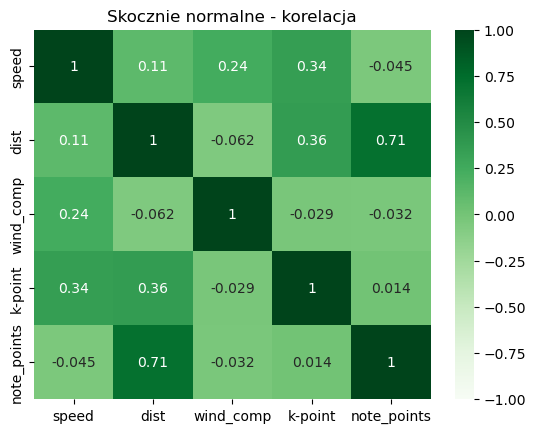

In [8]:
sns.heatmap(normal_hills.corr(), cmap='Greens', annot=True, vmin=-1, vmax=1).set(title="Skocznie normalne - korelacja")

### Skocznie duże

In [9]:
large_hills = dataset[(dataset['k-point'] > 100) & (dataset['k-point'] < 170)].dropna() # large hills

[Text(0.5, 1.0, 'Skocznie duże - korelacja')]

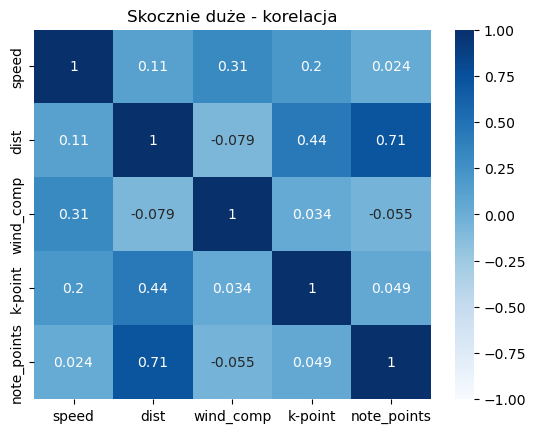

In [10]:
sns.heatmap(large_hills.corr(), cmap='Blues', annot=True, vmin=-1, vmax=1).set(title="Skocznie duże - korelacja")

### Skocznie mamucie

In [11]:
flying_hills = dataset[dataset['k-point'] > 170].dropna()

[Text(0.5, 1.0, 'Skocznie mamucie - korelacja')]

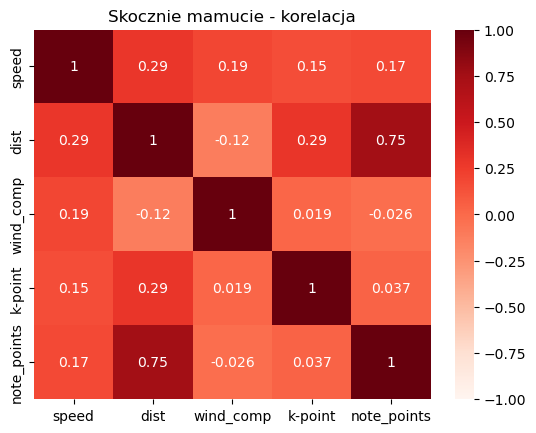

In [12]:
sns.heatmap(flying_hills.corr(), cmap='Reds', annot=True, vmin=-1, vmax=1).set(title="Skocznie mamucie - korelacja")

## Wnioski

Na podstawie macierzy korelacji można zauważyć, że bez względu na rodzaj skoczni istnieje silna zależność pomiędzy odległością uzyskaną
przez zawodników, a notami za styl. Jest to spowodowane tym, że sędziowie oceniając styl sugerują się
odległością i z automatu obniżają noty zawodnikom, którzy nie osiągają punktu konstrukcyjnego.

Inna zależność, jaką można wyczytać to wzrost wpływu wiatru na odległość zawodników w zależności od wielkości skoczni. Co ciekawe, nie jest on duży. Może mieć na to wpływ korekta rozbiegu podczas zawodów, co pozwala na zminimalizowanie wpływu wiatru na zawodników. Największa wartość współczynnik korelacji między wiatrem, a uzyskiwaną odległością występuje dla skoczni mamucich. Ma to odzwierciedlenie w praktyce, ponieważ na skoczniach mamucich wiatr wiejący pod narty daje większą korzyść, niż na skoczniach mniejszych.

## Szablon funkcji do analizy skoczka

In [81]:
def analyse_skijumper(data, codex):
    """
    data: dane z potrzebnymi kolumnami
    codex: id skoczka
    """
    results = data[data['codex_x'] == codex]
    results = results[['dist', 'k-point', 'codex_y', 'place', 'hill_size_x', 'note_points']] #optymalizacja jeszcze
    # results = results.copy()
    results['coef'] = results['dist'] / results['k-point']
    results['hs-jumps'] = results['dist'] >= results['hill_size_x']
    grouped_coefs = results.groupby('place')['coef'].mean()
    hs_jumps = results['hs-jumps'].sum()
    mean_notes = results['note_points'].mean()
    print(f"Ilość skoków za HS: {hs_jumps}")
    print(f"Średnia ocena za styl: {mean_notes:.2f}")

    plt.plot(grouped_coefs)
    plt.tick_params(axis='x', rotation=90)
    plt.show()

In [68]:
nh = merged[(merged['k-point'] > 75) & (merged['k-point'] < 100)]

In [69]:
lh = merged[(merged['k-point'] > 100) & (merged['k-point'] < 170)]

In [70]:
fh = merged[merged['k-point'] > 170]

## Gregor Schlierenzauer

Wykonamy analizę wyników Gregora Schlierenzauera
- z połączonego zbioru danych weźmiemy wszystkie jego wyniki
- policzymy stosunek dist/k-point
- później dołączymy jeszcze liczbę skoków za hs w zależności od skoczni

In [71]:
names[names['name'] == 'schlierenzauer gregor']

,name,codex
8,schlierenzauer gregor,5040.0


Ilość skoków za HS: 108
Średnia ocena za styl: 53.97


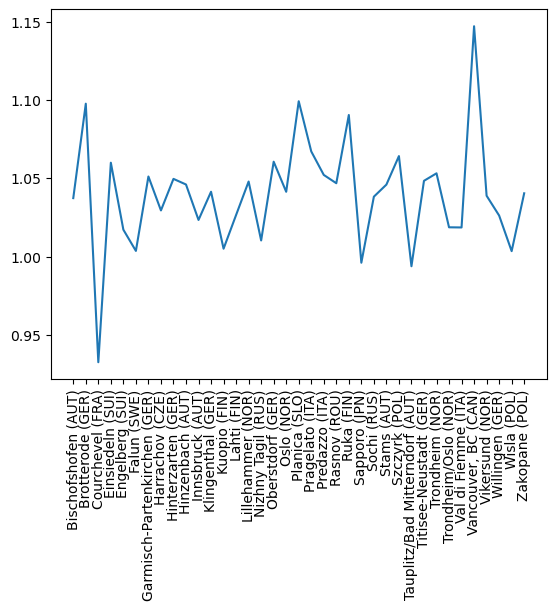

In [82]:
analyse_skijumper(merged, 5040)

Najlepszy średni stosunek między uzyskaną odległością, a punktem konstrukcyjnym Gregor uzyskał w Vancouver (skocznia normalna i skocznia duża liczone razem). No i ma to przełożenie na rzeczywistość, ponieważ w 2009 roku wygrał tam zawody ustanawiając rekord skoczni (149 metrów na skoczni K-125). Rok później podczas igrzysk olimpijskich zdobył tam 3 medale: 2 brązowe indywidualnie i 1 złoty drużynowo.

## Kamil Stoch

Teraz przyjrzyjmy się Polakowi

In [113]:
names[names['name'] == 'stoch kamil']

,name,codex
40,stoch kamil,4321.0


Ilość skoków za HS: 144
Średnia ocena za styl: 54.30


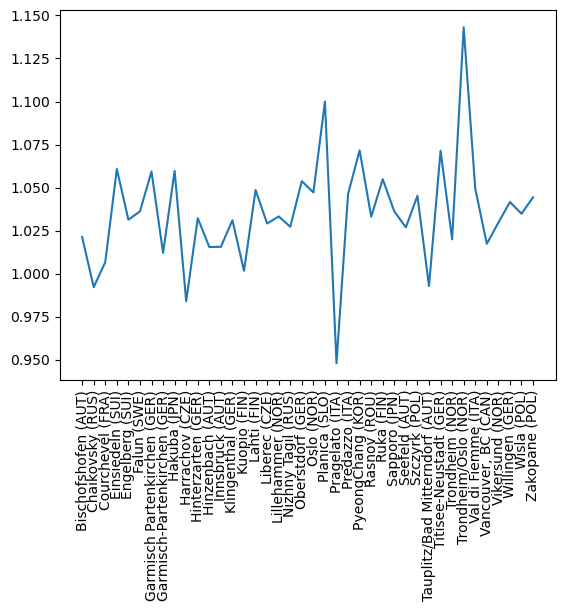

In [83]:
analyse_skijumper(merged, 4321)